<a href="https://colab.research.google.com/github/Sainath1998/EXPLORATORY-DATA-ANALYSIS-USING-PYTHON/blob/main/Cotton_Leaf_Disease_Image_Classification_RESNET152V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cotton Leaf Disease Prediction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Required modules

import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from zipfile import ZipFile
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 7)

In [ ]:
# Dividing into train and validation split

img_h = 300
img_w = 300

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255.,
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.2
)

train = datagen.flow_from_directory('/content/drive/My Drive/Datasets/train/',
    seed = 88,
    subset = 'training',
#     target_size = (img_h, img_w),
    batch_size = 32
)

valid = datagen.flow_from_directory(
    '/content/drive/My Drive/Datasets/val',
    seed = 88,
    subset = 'validation',
#     target_size = (img_h, img_w),
    batch_size = 32
)

In [ ]:
# Pre-trained model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
in_layer = tf.keras.layers.Input(shape=(None, None, 3))
resnet = ResNet152V2(include_top=False, weights='imagenet', input_tensor=in_layer)

for layer in resnet.layers:
    layer.trainable = False

inter = tf.keras.layers.GlobalMaxPooling2D()(resnet.output)
flatten = tf.keras.layers.Flatten()(inter)
output = tf.keras.layers.Dense(4, activation='softmax')(flatten)

resnet = tf.keras.models.Model(inputs=resnet.inputs, outputs=output)

In [ ]:
model = resnet

In [ ]:
initial_lr = 0.01


lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr,
    decay_steps=25,
    decay_rate=0.96,
    staircase=True
)

In [ ]:
# Defining callbacks

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', patience=10, verbose=0)
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_weights.hdf5', monitor='val_acc', mode='max', save_weights_only=True, verbose=0)

callbacks = [checkpoint, early_stopping]


In [ ]:
# Defining optimizer and loss functions

#optim = tf.keras.optimizers.RMSprop(learning_rate=lr_scheduler)
optim = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
loss_funct = 'CategoricalCrossentropy'

model.compile(optimizer=optim, loss=loss_funct, metrics=['acc'])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Fitting on the training data

epochs = 20
batch_size = 64

history = model.fit(train, validation_data=valid, epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Epoch 1/20
49/49 [==============================] - 19s 375ms/step - loss: 0.0091 - acc: 0.9987 - val_loss: 0.1110 - val_acc: 0.9688
Epoch 2/20
49/49 [==============================] - 18s 370ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.2856 - val_acc: 0.9844
Epoch 3/20
49/49 [==============================] - 18s 365ms/step - loss: 0.0054 - acc: 0.9994 - val_loss: 0.4471 - val_acc: 0.9219
Epoch 4/20
49/49 [==============================] - 18s 364ms/step - loss: 0.0022 - acc: 0.9994 - val_loss: 0.5556 - val_acc: 0.8750
Epoch 5/20
49/49 [==============================] - 18s 367ms/step - loss: 7.4563e-04 - acc: 1.0000 - val_loss: 0.5157 - val_acc: 0.9062
Epoch 6/20
49/49 [==============================] - 18s 367ms/step - loss: 0.0069 - acc: 0.9987 - val_loss: 0.8548 - val_acc: 0.9062
Epoch 7/20
49/49 [==============================] - 18s 366ms/step - loss: 0.0041 - acc: 0.9994 - val_loss: 0.4123 - val_acc: 0.9375
Epoch 8/20
49/49 [==============================] - 18s 366ms/ste

In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/Cotton-Leaf-Disease-Detection/'
tf.keras.models.save_model(model,path+'model_resnet.hdf5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


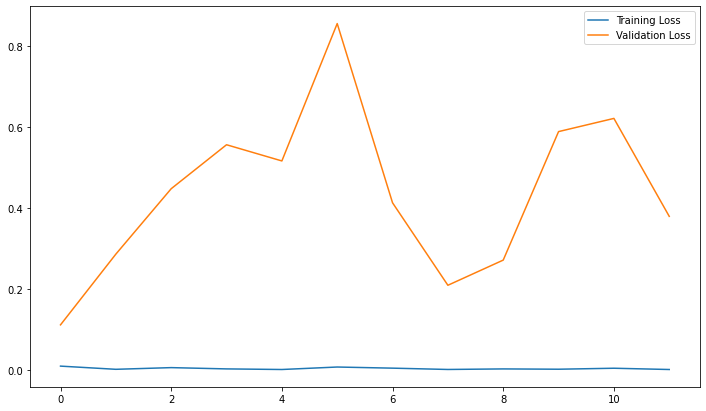

In [ ]:
# Plotting Loss

plt.plot(history.epoch, history.history['loss'], label='Training Loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
plt.legend()

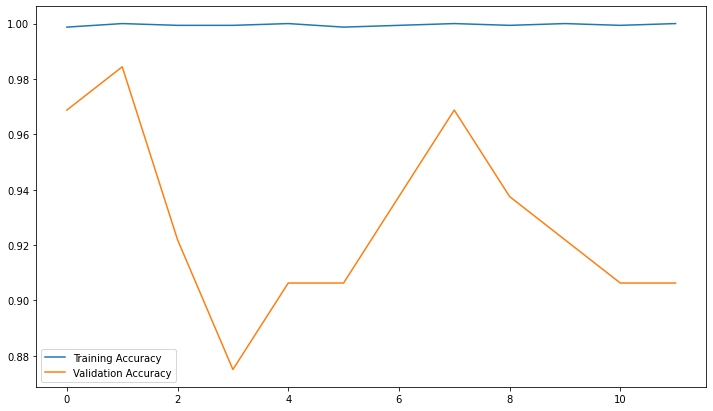

In [ ]:
# Plotting Accuracy

x_axis = range(epochs)

plt.plot(history.epoch, history.history['acc'], label='Training Accuracy')
plt.plot(history.epoch, history.history['val_acc'], label='Validation Accuracy')
plt.legend()

In [ ]:
# Loading the best model

model.load_weights('model_weights.hdf5')